In [92]:
from torch.nn import Sequential
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
hidden_layer_sizes = [6,12,18,24,30,36,42]
learning_rate = [0.0001,0.001,0.003,0.01,0.03,0.1,0.3]
betas = [(np.round(x,3),np.round(y,3)) for x,y in zip(np.arange(0.9,1,0.003),np.arange(0.9,1,0.003))]
epsilons = [np.round(x,10) for x in np.arange(1e-8,5e-8,1e-9)]


In [68]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 48, 3,2,1)
        self.LRN1 = nn.LocalResponseNorm(3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(48, 96,3,2,1)
        self.LRN2 = nn.LocalResponseNorm(1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(96,128,3,2,1)
        self.conv4 = nn.Conv2d(128,128,3,2,1)
        self.conv5 = nn.Conv2d(128,96,3,2,1)
        self.LRN5 = nn.LocalResponseNorm(1)
        self.fc1 = nn.Linear(96 , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.LRN1(F.sigmoid(self.conv1(x))))
        x = self.pool2(self.LRN2(F.sigmoid(self.conv2(x))))
        x = F.sigmoid(self.conv3(x))
        x = F.sigmoid(self.conv4(x))
        x = F.sigmoid((self.LRN5(self.conv5(x))))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [85]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding=1)
        self.norm = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3,padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.25)

        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)
        self.norm4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.norm(F.relu(self.conv1(x)))
        x = self.pool1(self.norm2(F.relu(self.conv2(x))))
        x = self.dropout1(x)

        x = self.norm3(F.relu(self.conv3(x)))
        x = self.pool2(self.norm4(F.relu(self.conv4(x))))
        x = self.dropout2(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [86]:
model = CNN()
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)


cuda


In [87]:
for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        # inputs,labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = crit(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.326
[1,  4000] loss: 1.950
[1,  6000] loss: 1.847
[1,  8000] loss: 1.684
[1, 10000] loss: 1.561
[1, 12000] loss: 1.463
[2,  2000] loss: 1.292
[2,  4000] loss: 1.215
[2,  6000] loss: 1.163
[2,  8000] loss: 1.109
[2, 10000] loss: 1.076
[2, 12000] loss: 1.079
Finished Training


In [88]:
#save the CNN
# PATH = './CNN_test_relu.pth'
PATH = './CNN_test_kaggle.pth'
torch.save(model.state_dict(), PATH)

In [89]:
#load the CNN
# PATH = './CNN_test_relu.pth'
# PATH = './CNN_test_sigmoid.pth'
PATH = './CNN_test_kaggle.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [90]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


In [91]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname} is {accuracy}")

Accuracy for class plane is 79.1
Accuracy for class car is 87.3
Accuracy for class bird is 51.2
Accuracy for class cat is 38.2
Accuracy for class deer is 55.6
Accuracy for class dog is 49.0
Accuracy for class frog is 81.2
Accuracy for class horse is 69.6
Accuracy for class ship is 74.2
Accuracy for class truck is 57.4


In [97]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cnn_from_kaggle')


ModuleNotFoundError: No module named 'tensorboard'

In [93]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

NameError: name 'writer' is not defined

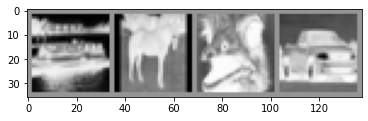

In [94]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)